/data/kirg/MMVAE/cigale/20260103185816/epochs/SpectraVAE/weights_epoch_150.weights.h5 /data/kirg/MMVAE/cigale/20260103185816/epochs/BandPassVAE/weights_epoch_150.weights.h5 /data/kirg/MMVAE/cigale/20260103185816/epochs/ParamVAE/weights_epoch_150.weights.h5


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_244']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_260']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_244']
Received: inputs=Tensor(shape=(100, 100))
  warnings.warn(msg)


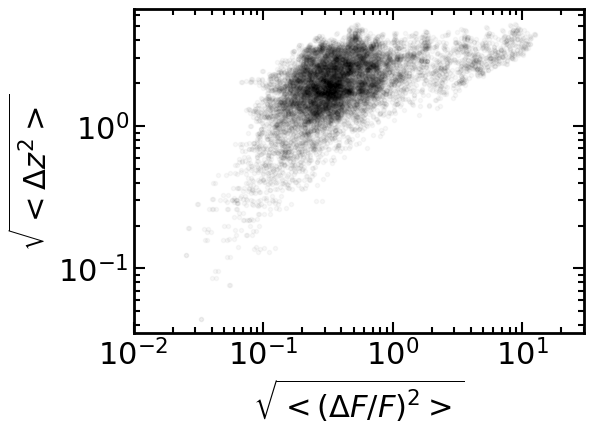

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_260']
Received: inputs=Tensor(shape=(100000, 5))
  warnings.warn(msg)


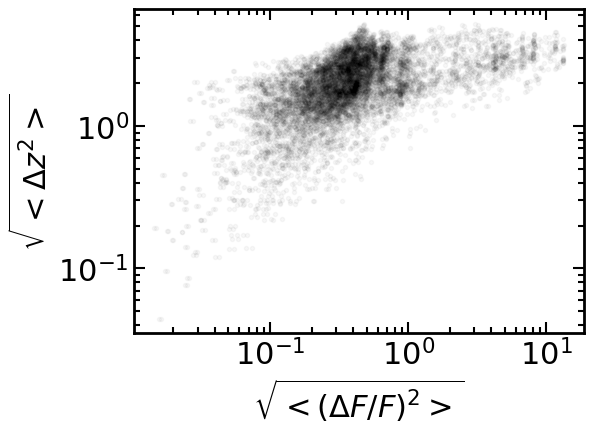

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import corner
from astropy.io import fits
from astropy.table import Table, vstack
from ParamVAEapply import ParamVAEapply
from BandPassVAE import BandPassVAE
from SpectraVAE import SpectraVAE
from ParamVAE import ParamVAE
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import numpy.ma as ma
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from utils import Sampling
from astropy.stats import sigma_clip
import matplotlib

matplotlib.rcParams.update({'font.size': 22})


def load_paramvaeapply(path: str, weight_file: str, input_dim: int, latent_dim: int, beta: float) -> ParamVAEapply:
    """
    Loads weights and builds a ParamVAEapply model from a saved epoch weight file.

    Parameters:
        weight_file (str): Path to the weights file (.h5).
        input_dim (int): Dimensionality of the input data.
        latent_dim (int): Latent space dimensionality.
        beta (float): Beta value for VAE loss.

    Returns:
        ParamVAEapply: A ready-to-use model with loaded weights.
    """
    # Build required submodels
    
    spvae_wf = os.path.join(os.path.join(path, 'SpectraVAE'), weight_file)
    bpvae_wf = os.path.join(os.path.join(path, 'BandPassVAE'), weight_file)
    parvae_wf = os.path.join(os.path.join(path, 'ParamVAE'), weight_file)
    print(spvae_wf, bpvae_wf, parvae_wf)
    spvae = SpectraVAE(100, latent_dim, beta=beta)
    spvae.compile() #optimizer=keras.optimizers.Adam())
    spvae(tf.zeros((1, 100)))  # Force model building
    spvae.load_weights(spvae_wf)

    bpvae = BandPassVAE(input_dim, latent_dim, spvae, beta=beta)
    bpvae.compile()#optimizer=keras.optimizers.Adam())
    bpvae(tf.zeros((1, input_dim)))  # Force model building
    bpvae.load_weights(bpvae_wf)

    # Attach ParamVAE
    parvae = ParamVAE(100, latent_dim, spvae, beta=beta, n_param=4)
    parvae.compile()#optimizer=keras.optimizers.Adam())
    parvae(tf.zeros((1, 100)))  # Force model building
    parvae.load_weights(parvae_wf)

    return ParamVAEapply(input_dim, latent_dim, bpvae, parvae, beta=beta), parvae, bpvae, spvae


latent_dim = 8 #64
beta = 1e-3
epoch = 1
n_param = 4
input_dim = 5
epoch = 150

chunk_size = 100_000      # user-defined chunk size
n_smpl = 10               # number of model samples per chunk

#id_run = '20251010162214'
id_run = '20260103185816'
weight_path = "/data/kirg/MMVAE/cigale/" + id_run + "/"
save_path = os.path.join(weight_path, 'epochs/')
plot_output_path = os.path.join(weight_path, 'cornerplots_train_' + id_run)


tr_smpl = os.path.join(weight_path, 'train_dataset_cigale_tmpl.fits')

weight_file = f"weights_epoch_{epoch:02d}.weights.h5"
parvaeapply, parvae, bpvae, spvae = load_paramvaeapply(
    save_path, weight_file, input_dim, latent_dim, beta
)



t = Table.read(tr_smpl)

inp_spec = t['Spec']
inp_sed = t['SED']
inp_par = t['Param']

inp_spec_sel = inp_spec[1000:1100]

spec_applied = spvae.apply(inp_spec_sel)

spec_applied_z = spec_applied[2]

dist2_inp_spec = np.sqrt(np.mean(((inp_spec_sel[:, None, :] - inp_spec_sel[None, :, :]) / inp_spec_sel[:, None, :])**2, axis=2))
dist2_z = np.sqrt(np.mean((spec_applied_z[:, None, :] - spec_applied_z[None, :, :])**2, axis=2))


plt.plot(dist2_inp_spec.flatten(), dist2_z.flatten(), 'k.', alpha=0.03)
#plt.hist2d(dist2_inp_spec.flatten(), dist2_z.flatten())
plt.xlabel(r'$\sqrt{<(\Delta F / F)^2>}$')
plt.ylabel(r'$\sqrt{<\Delta z^2>}$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, 3e1)

ax = plt.gca()
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.tick_params(which='major', length=8, width=1.5)
ax.tick_params(which='minor', length=4, width=1.5)

for spine in ax.spines.values():
    spine.set_linewidth(2)


plt.tight_layout()
plt.savefig(f'dLS_dF_spec_{id_run}.png')

plt.show()



inp_phot_sel = inp_sed[1000:1100]
phot_applied = bpvae.apply(inp_sed)
phot_applied_z = spec_applied[2]

dist2_inp_phot = np.sqrt(np.mean(((inp_phot_sel[:, None, :] - inp_phot_sel[None, :, :]) / inp_phot_sel[:, None, :])**2, axis=2))
dist2_z_phot = np.sqrt(np.mean((phot_applied_z[:, None, :] - phot_applied_z[None, :, :])**2, axis=2))

plt.plot(dist2_inp_phot, dist2_z_phot, 'k.', alpha=0.03)
plt.xlabel(r'$\sqrt{<(\Delta F / F)^2>}$')
plt.ylabel(r'$\sqrt{<\Delta z^2>}$')

#plt.hist2d(dist2_inp_phot.flatten(), dist2_z_phot.flatten())
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-2, 3e1)

ax = plt.gca()
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.tick_params(which='major', length=8, width=1.5)
ax.tick_params(which='minor', length=4, width=1.5)

for spine in ax.spines.values():
    spine.set_linewidth(2)


plt.tight_layout()
plt.savefig(f'dLS_dF_phot_{id_run}.png')

plt.show()



In [15]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')

z_min = 0.02
z_max = 1.4


hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > z_min) & (t_hsc_['z'] < z_max) & 
                (t_hsc_['g_kronflux_mag'] > 0) & 
                (t_hsc_['r_kronflux_mag'] > 0) & 
                (t_hsc_['i_kronflux_mag'] > 0) & 
                (t_hsc_['z_kronflux_mag'] > 0) & 
                (t_hsc_['y_kronflux_mag'] > 0) & 
                (t_hsc_['zwarn'] == 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])


n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']



n_smpl = 10

s_all = []
for i in range(n_smpl):
    s = parvaeapply(np.reshape(hsc_int[:n], (n,5)))
    s_all.append(s)

    
s_all = np.array(s_all)
z_infr_all = s_all[:,:,0]

p = np.array(hsz_z[:n])
res = s[:, 0] - p


print(z_infr_all.shape, p.shape)

idx = np.abs(z_infr_all - p).argmin(axis=0)

z_mean = np.nanmean(z_infr_all, axis=0)

z_infr_closest = z_infr_all[idx, np.arange(p.shape[0])]

N = 15


plx = z_mean
ply = z_mean - hsz_z
ply = np.array(ply)
plx = np.array(plx)
# Digitize plx into N bins
bins = np.linspace(0.0, 1.4, N + 1)
indices = np.digitize(plx, bins)

# Subtract sigma-clipped mean of ply in each bin
corrected_ply = ply.copy()


std_arr = []
zmean_arr = []
zbias_arr = []
n_arr = []

for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        cat_outl = abs(ply) > 0.3 
        clipped = sigma_clip(ply[bin_mask & ~cat_outl], sigma=2.5, maxiters=10, cenfunc='mean')
        mean_val = np.mean(clipped.data[~clipped.mask])
        std_val = np.nanstd(clipped.data[~clipped.mask])
        #std_val = np.nanstd(ply[bin_mask])
        print(np.mean(plx[bin_mask]), mean_val, std_val / (1 + np.mean(plx[bin_mask])), sum(bin_mask))
        std_arr.append(std_val)
        zbias_arr.append(mean_val)
        n_arr.append(sum(bin_mask))
        zmean_arr.append(np.mean(plx[bin_mask]))
        corrected_ply[bin_mask] -= mean_val


std_arr = np.array(std_arr)
zmean_arr = np.array(zmean_arr)
n_arr = np.array(n_arr)
meandz = np.nansum(n_arr * std_arr / (1 + zmean_arr)) / np.nansum(n_arr)

print(meandz)






/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_260']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


(10, 158663) (158663,)
0.050100572 -0.05284465381864434 0.05059193099365393 7910
0.14594139 -0.014117760152690478 0.055706581424734274 13459
0.23502089 0.01983190277142021 0.05914834451961219 20893
0.32782805 0.06895137317679487 0.05143640508743174 28980
0.41375968 0.09565255817586758 0.050953740550065456 16802
0.508267 0.09467997877828396 0.049795264714834336 7692
0.60621905 0.03622918264911009 0.04011887652821962 5018
0.7045043 0.02912917494038369 0.04995389289331331 6814
0.7946589 0.026184849332888623 0.04436221920394578 8762
0.88542974 0.058144014731101756 0.03275897929193963 9861
0.97960466 0.047838693374346916 0.03708800604565663 10479
1.0672499 -0.00896811807799352 0.06399030938106172 7077
1.1636769 0.02809401519705345 0.06621487995468116 3384
1.2518857 0.0458434821437567 0.05939975762341452 1955
1.3546741 0.0846481706226903 0.04408399735505868 1386
0.0505857800992823


0.0505857800992823


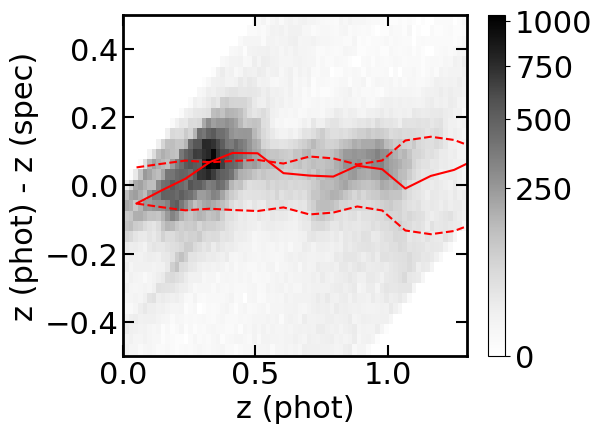

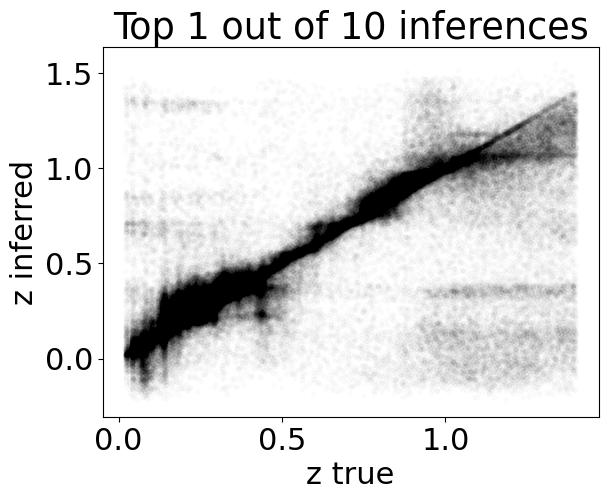

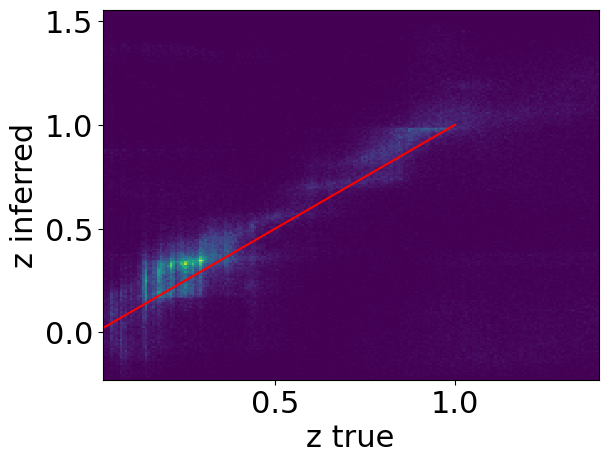

In [17]:
from matplotlib.colors import PowerNorm


std_arr = np.array(std_arr)
zmean_arr = np.array(zmean_arr)
n_arr = np.array(n_arr)
meandz = np.nansum(n_arr * std_arr / (1 + zmean_arr)) / np.nansum(n_arr)

print(meandz)

#plt.title('Mean value')
#plt.plot(hsz_z, s[:, 0], 'k.', alpha=0.01)
#plt.plot(hsz_z, z_mean-hsz_z, 'k.', alpha=0.005)
plt.hist2d(z_mean, z_mean-hsz_z, bins=100, 
           cmap='Greys',
           norm=PowerNorm(gamma=1/2))

plt.plot(zmean_arr, std_arr, color='red', linestyle='--')
plt.plot(zmean_arr, -std_arr, color='red', linestyle='--')
plt.plot(zmean_arr, zbias_arr, color='red')

plt.xlim(0, 1.3)
plt.ylim(-0.5, 0.5)
plt.colorbar()
plt.ylabel('z (phot) - z (spec)')
plt.xlabel('z (phot)')
ax = plt.gca()
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.tick_params(which='major', length=8, width=1.5)
ax.tick_params(which='minor', length=4, width=1.5)

for spine in ax.spines.values():
    spine.set_linewidth(2)


plt.tight_layout()
plt.savefig(f'dz_zphot_{id_run}.pdf')
plt.show()


plt.title('Top 1 out of 10 inferences')
plt.plot(p, z_infr_closest, 'k.', alpha=0.01)
plt.ylabel('z inferred')
plt.xlabel('z true')
plt.show()


plt.hist2d(hsz_z, s[:, 0], bins=200)
plt.plot([0,1],[0,1], color='red')
plt.ylabel('z inferred')
plt.xlabel('z true')
plt.show()
